In [401]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels as sms
from firthlogist import FirthLogisticRegression

import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm, truncnorm
from scipy.stats import beta


class QLearningModule:
    def __init__(self, *args, **kwargs):
        self.lr = kwargs.get('lr', .5)
        self.rl_temp = kwargs.get('rl_temp', 1)
        n_states, n_actions = kwargs.get('n_states', 2), kwargs.get('n_actions', 2)
        self.q = np.ones((n_states, n_actions)) * kwargs.get('q0', 50)

    def value_update(self, s, a, r):
        self.q[s, a] += self.lr * (r - self.q[s, a])


class PerceptualLogit:
    def __init__(self, *args, **kwargs):
        self.perceptual_temp = kwargs.get('perceptual_temp', 1)
        self.perceptual_model = kwargs.get('perceptual_model', 'logit')
        self.x = kwargs.get('x', np.arange(-1, 1, .2))

        self.firth_fit = None
        self.logit_fit = None
        # history of forcefields
        self.hist_ff = []
        # history of rewards (destroyed or not)
        self.hist_r = []

    def predictff(self, ff1=None, ff2=None):

        model = self.perceptual_model

        if ff1 is not None and ff2 is not None:
            to_select = np.array([ff1, ff2])
        else:
            # to_select = np.arange(len(self.x))
            to_select = np.arange(len(np.unique(self.hist_ff)))
            # print(len(np.unique(self.hist_ff)))
            # print(to_select)
        if model == 'logit':
            try:
                self.logit_fit = sm.Logit(self.hist_r, sm.add_constant(self.hist_ff))\
                    .fit_regularized(disp=0, start_params=[0,0])

                return self.logit_fit.predict(sm.add_constant(np.unique(self.hist_ff)))[to_select]
            # catch separation error and value errrors
            except (sms.tools.sm_exceptions.PerfectSeparationError,
             ValueError, np.linalg.LinAlgError):
                # equal probability for all forcefields
                try:
                    return 1/len(to_select) * np.ones(len(to_select))
                except ZeroDivisionError:
                    return 

        elif model == 'firth':
            try:
                self.firth_fit = FirthLogisticRegression(skip_ci=True, wald=False, fit_intercept=True)\
                    .fit(sm.add_constant(self.hist_ff), self.hist_r)
                return self.firth_fit.predict(sm.add_constant(np.unique(self.hist_ff)))[to_select]
            except:
                return 1/len(to_select) * np.ones(len(to_select))
        else:
            raise ValueError(
                'model must be either logit, firth, or val. Model is {}'.format(model))

    def get_intercept_and_slope(self):
        model = self.perceptual_model 
        if model == 'logit':
            if self.logit_fit is None:
                self.predictff()
                if self.logit_fit is None:
                    return np.array([0, 0])
            return np.clip(self.logit_fit.params, -10, 10)
        # elif model=='linear':
            # return
        elif model == 'firth':
            return np.array(self.firth_fit.coef_)
        elif model == 'val':
            return self.val_fit
        else:
            raise ValueError('model must be either logit or linear')


class HybridModelMultiply(PerceptualLogit, QLearningModule):
    def __init__(self, *args, **kwargs):
        PerceptualLogit.__init__(self, *args, **kwargs)
        QLearningModule.__init__(self, *args, **kwargs)

    def make_choice(self, s, ff1, ff2):
        def logsumexp(x):
            c = x.max()
            return c + np.log(np.sum(np.exp(x - c)))

        pdestroy = 1

        if ff1 is not None and ff2 is not None:
            pdestroy = self.predictff(ff1=ff1, ff2=ff2)

        x = ((self.q[s, :] * self.rl_temp)
             * pdestroy
             * self.perceptual_temp)

        p = np.exp(x - logsumexp(x))

        return np.random.choice(np.arange(2), p=p)

    def learn_perceptual(self, a, r):
        self.hist_ff.append(a)
        self.hist_r.append(r)
        self.predictff()
    
    def learn_value(self, s, a, r):
        self.value_update(s, a, r)
    
    def get_params(self, s=None):
        intercept, slope = self.get_intercept_and_slope()
        return {
            # alpha logit (utf8 character symbol as key)
            'α': intercept,
            # beta logit
            'β': slope,
            # alpha qlearning
            'lr': self.lr,
            # temperature qlearning
            'rl_temp': self.rl_temp,            
            # temperature logit
            'perceptual_temp': self.perceptual_temp
        }
        

class HybridModelAdd(QLearningModule, PerceptualLogit):
    def __init__(self, *args, **kwargs):
        QLearningModule.__init__(self, *args, **kwargs)
        PerceptualLogit.__init__(self, *args, **kwargs)

    def make_choice(self, s, ff1, ff2):
        def logsumexp(x):
            c = x.max()
            return c + np.log(np.sum(np.exp(x - c)))

        x1 = np.log(self.q[s, :]) * self.rl_temp
        x2 = np.log(self.predictff(ff1=ff1, ff2=ff2)) * self.perceptual_temp
        x = x1 + x2

        p = np.exp(x - logsumexp(x))

        try:
            return np.random.choice(np.arange(2), p=p)
        except ValueError as e:
            print(e)
            return np.random.choice(np.arange(2), p=[0.5, 0.5])


class RandomModel:
    def __init__(self, *args, **kwargs):
        pass

    @staticmethod
    def make_choice(s, ff1, ff2):
        return np.random.choice(np.arange(2))

    @staticmethod
    def learn_perceptual(s, a, r):
        pass
    
    @staticmethod
    def learn_value(s, a, r):
        pass


class NormativeModelPerceptual:
    def __init__(self, *args, **kwargs):
        # super().__init__(*args, **kwargs)
        # slope prior
        self.slope_prior = kwargs.get('slope_prior', 2)
        # leak parameter
        self.leak = kwargs.get('leak', 0)
        # x values = forcefield values
        self.x = kwargs.get('x', np.arange(-1, 1, 10))
        
        # possible values for the slope
        self.slope_range = kwargs.get(
        'slope_range', np.arange(-10, 10, 0.01))

        # initialize logposterior for the slope to prior
        self.lp_slope = np.log(norm.pdf(self.slope_range, 0, self.slope_prior))

        # define logit function
        self.logit = lambda x: 1 / (1+np.exp(x))
    

    def perceptual_update(self, choice, destroyed):
        v = -self.slope_range*choice if destroyed else self.slope_range*choice
        # compute log likelihood
        ll = np.log(self.logit(v))
        # update log posterior
        self.lp_slope += ll
        self._apply_leak()
    
    def predictff(self, ff1=None, ff2=None):
        if ff1 is None and ff2 is None:
            # predict p(destroy) for all forcefields
            to_select = np.arange(len(self.x))
        else:
            # predict p(destroy) for 2 (displayed) forcefields
            to_select = np.array([ff1, ff2])
        return self.logit(-self.get_slope()*self.x[to_select])

    def get_slope(self):
        w = np.exp(self.lp_slope-np.max(self.lp_slope))
        slope = np.sum(w*self.slope_range)/np.sum(w)
        return slope
    #
    def _apply_leak(self):
        self.lp_slope *= 1-self.leak


class NormativeModelValue:
    def __init__(self, *args, **kwargs):
        # super().__init__(*args, **kwargs)
        self.sigma_prior = kwargs.get('sigma_prior', .2)
        self.std_prior = kwargs.get('std_prior', .2)
        self.leak = kwargs.get('leak', 0)
        self.nstate = kwargs.get('nstate', 2)

        # possible values for the difference between two options
        self.sigma_range = kwargs.get('sigma_range', np.arange(-1, 1, 0.002))

        # initialize logposterior for the slope to prior
        self.lp_sigma = [
            np.log(tnormpdf(0.5*(1+self.sigma_range), 0.5, self.sigma_prior))
            for _ in range(self.nstate)
        ]
    
    def value_update(self, s, a, r):
        v = 1-self.sigma_range if a else 1+self.sigma_range
        # compute log likelihood
        ll = np.log(tnormpdf(r, 0.5*(v), self.std_prior))
        # update log posterior
        self.lp_sigma[s] += ll
        self._apply_leak()

    def get_sigma(self, s):
        w = np.exp(self.lp_sigma[s]-np.max(self.lp_sigma[s]))
        sigma = np.sum(w*self.sigma_range)/np.sum(w)
        return sigma 

    def _apply_leak(self):
        self.lp_sigma *= 1-self.leak 


class NormativeModel(NormativeModelValue, NormativeModelPerceptual):
    def __init__(self, *args, **kwargs):
        NormativeModelValue.__init__(self, *args, **kwargs)
        NormativeModelPerceptual.__init__(self, *args, **kwargs)

        self.temp = kwargs.get('temp', 1e6)
        
    def make_choice(self, s, ff1, ff2):
        p = self.predictff(ff1, ff2) if ff1 is not None else 1
        ev1, ev2 = .5 * (1+self.get_sigma(s)*(np.array([1, -1]))) * p
        choice = int(np.random.random() > 1/(1+np.exp(-self.temp*(ev1-ev2))))
        return choice 
    
    def learn_perceptual(self, a, r):
        self.perceptual_update(a, r)
    
    def learn_value(self, s, a, r):
        self.value_update(s, a, r)
    
    def get_params(self, s=None):
        return {
            # beta logit (utf8 character symbol as key)
            'β': self.get_slope(),
            # sigma (diff between two options) (utf8 character symbol as key)
            'σ': self.get_sigma(s) if s is not None
             else [self.get_sigma(s) for s in range(self.nstate)],
        }


def tnormpdf(x, m, s):
    x = x + np.zeros_like(m)
    p = norm.pdf(x, m, s)
    cdf_range = norm.cdf(1, m, s) - norm.cdf(0, m, s)
    p = p / (s * cdf_range)
    return p

def tnormpdf2(x, loc, std, lb=0, ub=1):
    # TODO: check why it doesn't work
    a, b = (lb-loc)/std, (ub-loc)/std
    return truncnorm(a,b, loc=loc).pdf(x)

def tnormrdn(loc, std, lb=0, ub=1, size=1):
    a, b = (lb-loc)/std, (ub-loc)/std
    return truncnorm(a, b, loc=loc, scale=std).rvs(size=size)
    

(300,)


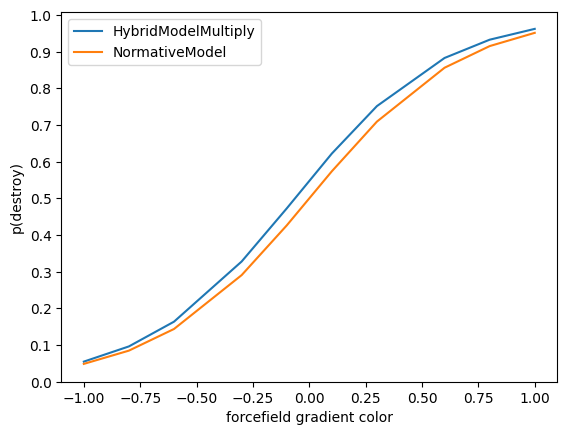

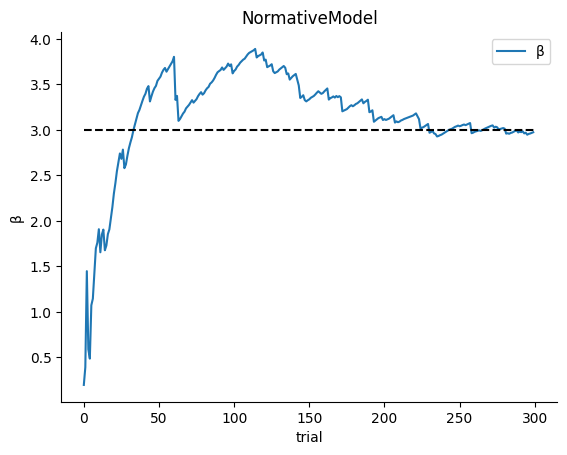

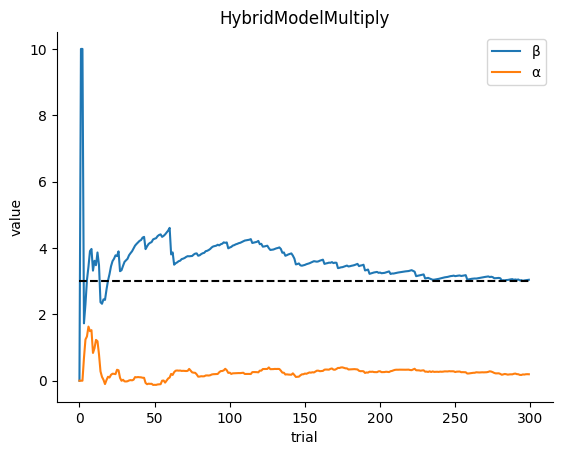

In [419]:
# -----------------------------------------------------------------
# simulation perceptual training
# -----------------------------------------------------------------

# old way to simulate perceptual training
# n_perceptual_trials_per_color = 30
# # probability of destroying the target
# pff = np.repeat(np.linspace(0, 1, 10).round(
#     1), n_perceptual_trials_per_color).flatten()
# # rewards (1 if target destroyed, 0 otherwise), using the real probabilities in pff
# rff = np.random.binomial(1, pff, size=len(pff))

# # forcefield chosen by the subject
# ff = np.repeat(np.linspace(-1, 1, 10).round(1),
#                n_perceptual_trials_per_color).flatten()


# hyperparameters
ntrial = 300
nagent = 1
true_slope = 3
true_leak = 0

# forcefield chosen by the subject
ff = np.repeat(np.linspace(-1, 1, 10).round(1), ntrial/10).flatten()
# rewards (1 if target destroyed, 0 otherwise)
rff = np.random.binomial(1, 1/(1+np.exp(-true_slope*ff)), size=ntrial)
print(ff.shape)
# model parameters
normative_param = dict(slope_prior=true_slope, temp=1e6, leak=0, x=np.unique(ff))
hybrid_param = dict(perceptual_temp=5, perceptual_model='logit',
    lr=.5, rl_temp=5, n_states=2, n_actions=2, q0=50)

# data frame to store the results
df = []

# -----------------------------------------------------------------
# RUN
# -----------------------------------------------------------------
for agent in range(nagent):
    # randomize all arrays
    idx = np.arange(len(ff))
    np.random.shuffle(idx)
    ff, rff = ff[idx],  rff[idx]

 
    for model, param in zip(
        (HybridModelMultiply, NormativeModel, ),
            (hybrid_param, normative_param)):

        m = model(**param)
        
        for t in range(len(ff)):
            m.learn_perceptual(ff[t], rff[t])

            df.append(
                {
                    'params': m.get_params(),
                    'trial': t,
                    'model': model.__name__,
                    'agent': agent,
                }
            )

        if agent > 0:
            continue
        # plot the learned logit function
        x, y = np.unique(ff), m.predictff()
        sns.lineplot(x=x, y=y, label=model.__name__)
        plt.ylabel('p(destroy)')
        plt.xlabel('forcefield gradient color')
        plt.yticks(np.arange(0, 1.1, .1))

# -----------------------------------------------------------------
# PLOT
# -----------------------------------------------------------------
# plot evolution of parameters for each model
df = pd.DataFrame(df)
df = pd.concat([df.drop(['params'], axis=1), df['params'].apply(pd.Series)], axis=1)

plt.figure()
sns.lineplot(x='trial', y='β', data=df[df['model']=='NormativeModel'], label='β', n_boot=0, errorbar='se')
# plot true slope
plt.plot([0, ntrial], [true_slope, true_slope], '--', color='k', label='true slope')
sns.despine()
plt.title('NormativeModel')


plt.figure()
mask = df.model == 'HybridModelMultiply'
sns.lineplot(x='trial', y='β', data=df[mask], label='β', n_boot=0, errorbar='se')
sns.lineplot(x='trial', y='α', data=df[mask], label='α', n_boot=0, errorbar='se')
# plot true slope
plt.plot([0, ntrial], [true_slope, true_slope], '--', color='k', label='true slope')
plt.ylabel(('value'))
plt.title('HybridModelMultiply')
sns.despine()
# plt.ylim(-5, 5)



C:\Users\basil\AppData\Local\Temp\ipykernel_21892\1961440301.py:272: RuntimeWarning: overflow encountered in exp
  choice = int(np.random.random() > 1/(1+np.exp(-self.temp*(ev1-ev2))))


0.3063651377813891


<AxesSubplot: xlabel='trial', ylabel='σ'>

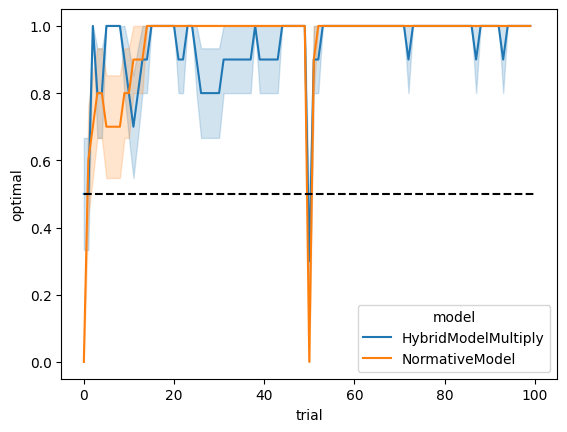

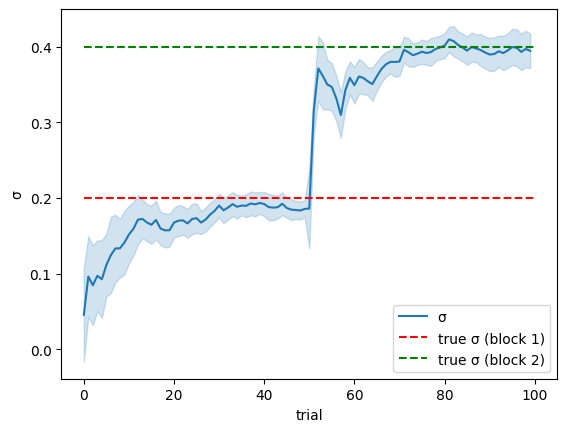

In [399]:
# -----------------------------------------------------------------
# simulation option value training
# -----------------------------------------------------------------
# parameters to tune
nagents = 10
models = (HybridModelMultiply, NormativeModel)
conditions = [
    [.6, .4],
    [.7, .3]
]
std = .2 
ntrial_per_condition = 50

condition_idx = np.repeat(
    np.arange(len(conditions)), ntrial_per_condition).flatten()

ntrials = len(condition_idx)

# data frame to store the results
df = []

# model parameters
normative_param = dict(sigma_prior=.2, temp=1e5)
hybrid_param = dict(perceptual_temp=5, perceptual_model='logit',
    lr=.5, rl_temp=1e6, n_states=2, n_actions=2, q0=.5)
params = (hybrid_param, normative_param)

# -----------------------------------------------------------------
# RUN
# -----------------------------------------------------------------
for agent in range(nagents):
    for model, param in zip(models, params):
        m = model(**param)
        for t in range(ntrials):
            
            s = condition_idx[t]
            a = m.make_choice(s, None, None)
            r = tnormrdn(conditions[s][a], std)

            m.learn_value(s, a, r)
            df.append(
                {
                    'trial': t,
                    'model': model.__name__,
                    'agent': agent,
                    's': s,
                    'a': a,
                    'r': r,
                    'optimal': a==0,
                    'params': m.get_params(s=s),
                }
            )

            
#----------------------------------------------------------------------------------
# PLOT
#----------------------------------------------------------------------------------
df = pd.DataFrame(df)
# add parameters to the dataframe
df = pd.concat([df.drop(['params'], axis=1), df['params'].apply(pd.Series)], axis=1)
# print sigma
# sns.lineplot(x='trial', y='',
sns.lineplot(x='trial', y='optimal', data=df, hue='model', errorbar='se', n_boot=0)
plt.plot([0, ntrials], [0.5, 0.5], '--', color='k')
#

plt.figure()
sns.lineplot(x='trial', y='σ',
data=df[df.model=='NormativeModel'], label='σ', n_boot=0, errorbar='se')
# plot true sigma (.2 & .4)
sns.lineplot(x=[0, ntrials], y=[.2, .2], ls='--', color='r', label='true σ (block 1)')
sns.lineplot(x=[0, ntrials], y=[.4, .4], ls='--', color='g', label='true σ (block 2)')

In [5]:
# -----------------------------------------------------------------
# Full
# -----------------------------------------------------------------
# np.random.seed(0)

# parameters to tune
nagents = 1000
models = (RandomModel, NormativeModel, HybridModelMultiply)
conditions = [
    [.6, .4],
    [.7, .3]
]
std = .2 

n_trials_per_condition = 50
p_ff = np.linspace(0, 1, 10)
ntrials = n_trials_per_condition*len(conditions)

# generate random parameters for HybridModelMultiply
lr = np.random.uniform(0, 1, nagents)
rl_temp = np.random.normal(2, .8, nagents)
perceptual_temp = np.random.normal(2, .8, nagents)


#to fill
agents = []
df_list = []

from tqdm.notebook import tqdm
# if pbar exists
try:
    pbar.refresh()
except NameError:
    pass
pbar = tqdm(total=ntrials*nagents*len(models))

for model in models:
    for agent in range(nagents):

        conditions_idx = np.repeat(np.arange(len(conditions)), n_trials_per_condition)
        ff1 = np.random.choice(np.linspace(-1, 1, 1e6), size=n_trials_per_condition*len(conditions))
        ff1 = np.random.choice(np.linspace(-1, 1, 1e6), size=n_trials_per_condition*len(conditions))

        # m = model(
                # lr=.5,#lr[agent]
                # rl_temp=1,#rl_temp[agent]
                # perceptual_temp=1,#perceptual_temp[agent],
                # n_states=2,
                # n_actions=2,
                # q0=np.mean(conditions),
                # perceptual_model='logit'
        # )
        m = model(
            leak=0,
            slope=2,
            x=np.unique(sp))

        agents.append(m)
        model_name = model.__name__
        
        # np.random.shuffle(ff1)
        # np.random.shuffle(ff2)

        # hist_sp = list(sp*10)
        # hist_rp = list(rp)
        
        cumulative_reward = 0

        for t in range(ntrials):

            s_rl = conditions_idx[t]

            sp1 = ff1[t]
            sp2 = ff2[t]
            
            # a = m.make_choice(s_rl, hist_sp, hist_rp, sp1, sp2)
            a = m.make_choice(s_rl, sp1, sp2)

            r = np.random.normal(conditions[s_rl][a], std) 
            
            cumulative_reward += r

            chosen_ff = sp1 if a == 0 else sp2
            unchosen_ff = sp2 if a == 0 else sp1

            destroyed = np.random.random() < p_ff[chosen_ff]
            
            if destroyed:
                m.rl_learn(s_rl, a, r)

            # add chosen ff to history
            hist_sp.append(chosen_ff)
            hist_rp.append(destroyed)
            
            #check that the model chose the best ff
            corr_ff = p_ff[chosen_ff] > p_ff[unchosen_ff]
            corr_rl = a == 0 

            unchosen = 1 if a == 0 else 0

            corr_full = corr_ff and corr_rl
            
            corr_ev = (conditions[s_rl][a] * p_ff[chosen_ff]) > (conditions[s_rl][unchosen] * p_ff[unchosen_ff])
            
            df_list.append({
                'trial': t,
                'chosen_ff': chosen_ff,
                'unchosen_ff': unchosen_ff,
                'choice': a,
                'unchosen': unchosen,
                'correct_ff': corr_ff,
                'correct_rl': corr_rl,
                'correct_full': corr_full,
                'correct_ev': corr_ev,
                'agent': agent,
                'rl_temp': rl_temp[agent],
                'perceptual_temp': perceptual_temp[agent],
                'learning_rate': lr[agent],
                'model': model_name,
                'cumulative_reward': cumulative_reward
            })
            pbar.update()
pbar.refresh()

df = pd.DataFrame(df_list)



  0%|          | 0/300000 [00:00<?, ?it/s]

C:\Users\basil\AppData\Local\Temp\ipykernel_14016\3772640965.py:201: RuntimeWarning: invalid value encountered in log
  x1 = np.log(self.q[sr, :]) * self.rl_temp


probabilities contain NaN
[4.31417634        nan] [-0.2707916  -1.33132952] [4.04338474        nan]
probabilities contain NaN
[4.40746443        nan] [-0.42711243 -0.16308408] [3.980352      nan]
probabilities contain NaN
[4.36285064        nan] [-0.50734044 -0.20716704] [3.85551019        nan]
probabilities contain NaN
[4.36285064        nan] [-2.33177254 -1.43899713] [2.0310781       nan]
probabilities contain NaN
[4.36285064        nan] [-0.32655936 -0.20403919] [4.03629128        nan]
probabilities contain NaN
[4.5447047       nan] [-0.74830708 -2.35659519] [3.79639762        nan]
probabilities contain NaN
[4.54043533        nan] [-2.33465655 -1.05278528] [2.20577878        nan]
probabilities contain NaN
[4.54043533        nan] [-0.3193354  -2.85706604] [4.22109993        nan]
probabilities contain NaN
[4.54043533        nan] [-1.45297441 -0.11977436] [3.08746092        nan]
probabilities contain NaN
[4.54043533        nan] [-1.46582509 -0.50054272] [3.07461023        nan]
probabil

<AxesSubplot: xlabel='trial', ylabel='cumulative_reward'>

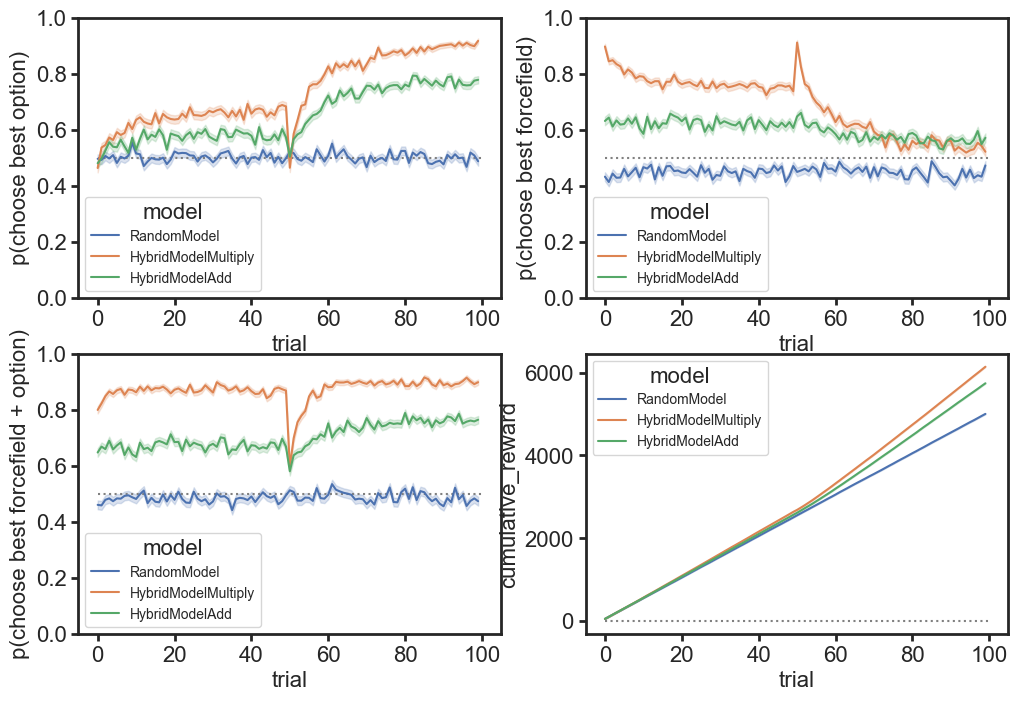

In [6]:
sns.set({'figure.figsize': (12, 8)})
sns.set_style('ticks')
# set legend fontsize
plt.rcParams['legend.fontsize'] = 10

plt.subplot(2, 2, 1)
# plot dotted line at .5
plt.plot([0, 100], [.5, .5], color='grey', linestyle=':')
sns.lineplot(x='trial', y='correct_rl', data=df, hue='model', n_boot=0, errorbar='se')
plt.ylabel('p(choose best option)')
plt.ylim(0, 1 )

plt.subplot(2, 2, 2)
# plot dotted line at .5
plt.plot([0, 100], [.5, .5], color='grey', linestyle=':')
sns.lineplot(x='trial', y='correct_ff', data=df, hue='model', n_boot=0, errorbar='se')
plt.ylabel('p(choose best forcefield)')
plt.ylim(0, 1 )

plt.subplot(2, 2, 3)
# plot dotted line at .5
plt.plot([0, 100], [.5, .5], color='grey', linestyle=':')
sns.lineplot(x='trial', y='correct_ev', data=df, hue='model', n_boot=0, errorbar='se')
plt.ylabel('p(choose best forcefield + option)')
plt.ylim(0, 1 )

plt.subplot(2, 2, 4)
# plot dotted line at .5
plt.plot([0, 100], [.5, .5], color='grey', linestyle=':')
sns.lineplot(x='trial', y='cumulative_reward', data=df, hue='model', n_boot=0, errorbar='se')
# plt.ylabel('choice (option A = 0 ; option B = 1)')
# plt.ylim(0, 1 )



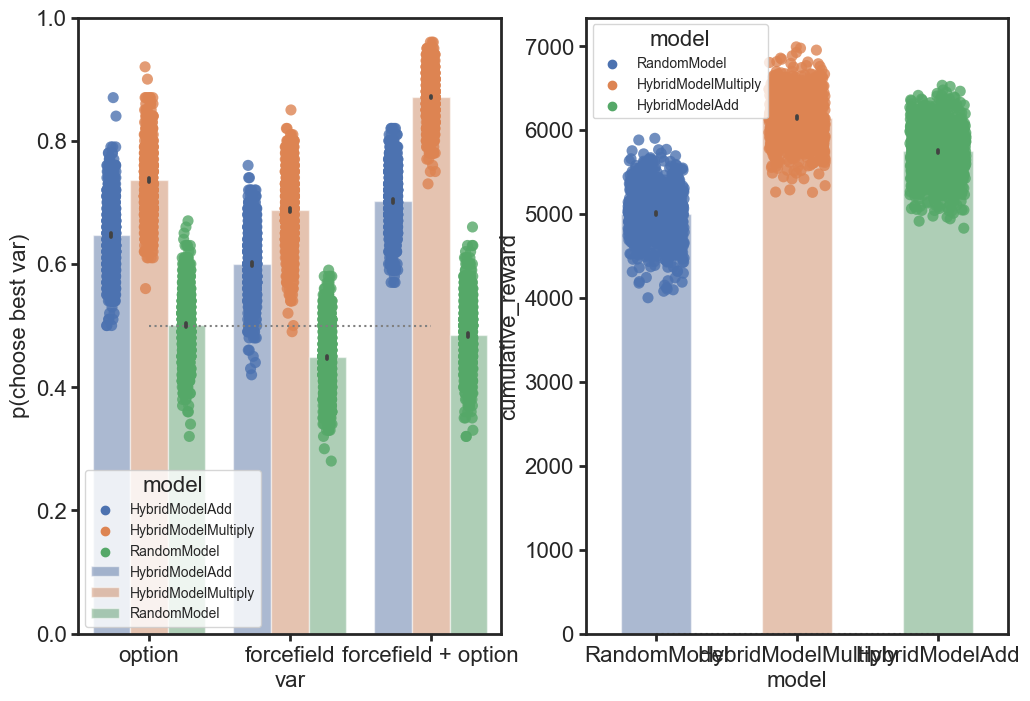

c:\Users\basil\AppData\Local\Programs\Python\Python310\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
c:\Users\basil\AppData\Local\Programs\Python\Python310\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


T     dof alternative         p-val               CI95%  \
T-test -16.455068  199998   two-sided  8.458813e-61  [-141.55, -111.42]   

         cohen-d       BF10  power  
T-test  0.073589  2.855e+56    1.0

In [7]:
sns.set({'figure.figsize': (12, 8)})
sns.set_style('ticks')

plt.subplot(1, 2, 1)
# plot dotted line at .5
plt.plot([0, 2], [.5, .5], color='grey', linestyle=':')
avg = df.groupby(['agent', 'model'], as_index=False).mean()
new_df = pd.DataFrame({'score': np.array([avg['correct_rl'], avg['correct_ff'], avg['correct_ev']]).flatten(), 'type': np.array(
    ['option',] * len(avg['correct_rl'])
    + ['forcefield',] * len(avg['correct_ff'])
    + ['forcefield + option',] * len(avg['correct_ev'])).flatten(),
    'model':np.array([avg['model'], avg['model'], avg['model']]).flatten()})

ax = sns.barplot(x='type', y='score', data=new_df,alpha=.5, zorder=0, hue='model', dodge=True)
plt.legend([],[], frameon=False)
sns.stripplot(x='type', y='score', data=new_df, hue='model', jitter=True, alpha=.8, size=8, zorder=1, dodge=True)
plt.ylabel('p(choose best var)')
plt.xlabel('var')
plt.xticks([0, 1, 2], ['option', 'forcefield', 'forcefield + option'])
plt.ylim(0, 1)


plt.subplot(1,2, 2)
# plot dotted line at .5
plt.plot([0, 2], [.5, .5], color='grey', linestyle=':')
last_trial = df[df['trial'] == 99]

ax = sns.barplot(x='model', y='cumulative_reward', data=last_trial, alpha=.5, zorder=0, width=.5)
sns.stripplot(x='model', y='cumulative_reward', data=last_trial, hue='model', jitter=.2, alpha=.8, size=8, zorder=1)
plt.show()

import pingouin as pg
pg.ttest(df[df['model'] == 'HybridModelAdd']['cumulative_reward'], df[df['model'] == 'HybridModelMultiply']['cumulative_reward'])



C:\Users\basil\AppData\Local\Temp\ipykernel_14016\144853987.py:35: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg = df.groupby('agent').mean()


(0.0, 1.0)

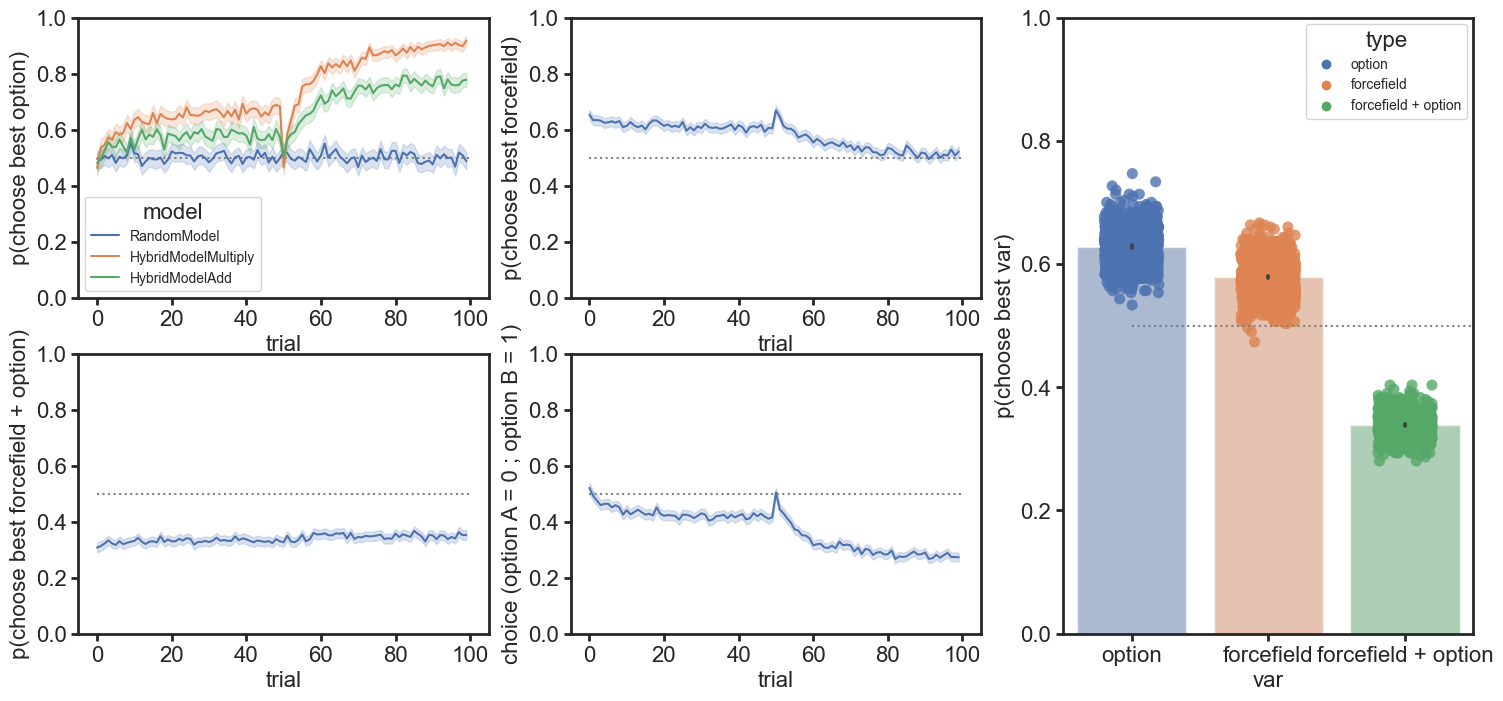

In [8]:
sns.set({'figure.figsize': (18, 8)})
sns.set_style('ticks')

plt.subplot(2, 3, 1)
# plot dotted line at .5
plt.plot([0, 100], [.5, .5], color='grey', linestyle=':')
sns.lineplot(x='trial', y='correct_rl', hue='model', data=df)
plt.ylabel('p(choose best option)')
plt.ylim(0, 1 )

plt.subplot(2, 3, 2)
# plot dotted line at .5
plt.plot([0, 100], [.5, .5], color='grey', linestyle=':')
sns.lineplot(x='trial', y='correct_ff', data=df)
plt.ylabel('p(choose best forcefield)')
plt.ylim(0, 1 )

plt.subplot(2, 3, 4)
# plot dotted line at .5
plt.plot([0, 100], [.5, .5], color='grey', linestyle=':')
sns.lineplot(x='trial', y='correct_full', data=df)
plt.ylabel('p(choose best forcefield + option)')
plt.ylim(0, 1 )

plt.subplot(2, 3, 5)
# plot dotted line at .5
plt.plot([0, 100], [.5, .5], color='grey', linestyle=':')
sns.lineplot(x='trial', y='choice', data=df)
plt.ylabel('choice (option A = 0 ; option B = 1)')
plt.ylim(0, 1 )

plt.subplot(1, 3, 3)
# plot dotted line at .5
plt.plot([0, 3], [.5, .5], color='grey', linestyle=':')
avg = df.groupby('agent').mean()
# 1s column = score, 2nd colum type ('rl', 'ff', 'full')
new_df = pd.DataFrame({'score': np.array([avg['correct_rl'], avg['correct_ff'], avg['correct_full']]).flatten(), 'type': np.array(
    ['option',] * len(avg['correct_rl'])
    + ['forcefield',] * len(avg['correct_ff'])
    + ['forcefield + option',] * len(avg['correct_full'])).flatten()})

sns.barplot(x='type', y='score', data=new_df,alpha=.5, zorder=0)
sns.stripplot(x='type', y='score', data=new_df, hue='type', jitter=.2, alpha=.8, size=8, zorder=1)
plt.ylabel('p(choose best var)')
plt.xlabel('var')
plt.xticks([0,1,2], ['option', 'forcefield', 'forcefield + option'])
plt.ylim(0,1)



In [9]:
#plot the distribution of model parameters
sns.set({'figure.figsize':(11,8)})
sns.set_style('ticks')

params = pd.DataFrame(
    {
        'param': np.array(
            ['lr', ] * nagents
          + ['rl_temp', ] * nagents
          + ['perceptual_temp', ] * nagents
        ).flatten(),
        'value': np.array(
            [agent.lr for agent in agents]
          + [agent.rl_temp for agent in agents]
          + [agent.perceptual_temp for agent in agents]
        ).flatten(),
    }
)

fig, ax = plt.subplots(ncols=2, nrows=1)
print(ax)

sns.displot(
    data=params,
    x='value',
    hue='param',
    kind='kde',
    fill=True,
    palette='colorblind',
    # split distributions  into 3 layers
    # (one for each parameter)
    # to make the plot more readable
    ax=ax[0]
    
)

d = df.groupby(['agent'], as_index=False).mean()
d.drop(['trial', 'choice', 'chosen_ff', 'unchosen', 'unchosen_ff', 'agent'], axis=1, inplace=True)
# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax[1])


AttributeError: 'RandomModel' object has no attribute 'lr'